In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import col,explode,array
from pyspark.sql.types import *
import pyspark.pandas as pd
import numpy as np
from math import sin, asin, cos, radians, fabs, sqrt, dist
import matplotlib.pyplot as plt

/usr/lib/spark/python/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


<h3>Part.1 Load Airbnb Listing Data<h3>

In [3]:
# Load london airbnb listing for test from insideairbnb
!wget "https://data.insideairbnb.com/united-kingdom/england/london/2023-12-10/data/listings.csv.gz"  -P /geodata

--2024-05-05 15:12:18--  https://data.insideairbnb.com/united-kingdom/england/london/2023-12-10/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 18.165.227.117, 18.165.227.80, 18.165.227.68, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|18.165.227.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32102141 (31M) [application/x-gzip]
Saving to: ‘/geodata/listings.csv.gz’

listings.csv.gz     100%[===================>]  30.61M  23.9MB/s    in 1.3s    

2024-05-05 15:12:20 (23.9 MB/s) - ‘/geodata/listings.csv.gz’ saved [32102141/32102141]



In [4]:
# if used download data then decompress the file and write into HDFS
! gzip -d /geodata/listings.csv.gz
! hadoop fs -put /geodata/listings.csv /

In [2]:
# Use uploaded res.csv AirBnB data after processed by Data_Pre_Processing.ipynb
! hadoop fs -put /geodata/res.csv /

In [5]:
# load the airbnb data and the tourism cluster center data to df
res_airbnb_load = spark.read.format('csv') \
        .option("header", "true") \
        .option("multiLine", "true") \
        .option("escape", "\"") \
        .option("quote", "\"") \
        .load('/res.csv/')

combined_center_load = spark.read.parquet('/combined_cluster_centers')

In [6]:
# check airbnb df schema
res_airbnb_load.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- price: string (nullable = true)
 |-- sentiment_score: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- name: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- review_scores_rating: string (nullable = true)
 |-- squared_error: string (nullable = true)



In [7]:
# check airbnb listings count
n = res_airbnb_load.count()
print(n)

101698


In [8]:
airbnb_df = res_airbnb_load

In [9]:
# Since most tourism spot does not change location on map, so cluster center can serve as fix dataframe
combined_center_load_df = combined_center_load.select('city', 'lat', 'lon').withColumn('point', F.array(F.col('lat'),F.col('lon'))).toPandas()
combined_center_load_df = combined_center_load_df.dropna()
combined_center_load_df

,city,lat,lon,point
0,paris,48.939426,2.317931,"[48.93942642211914, 2.3179314136505127]"
1,paris,48.846798,2.347107,"[48.846797943115234, 2.347106695175171]"
2,paris,48.885242,2.318553,"[48.8852424621582, 2.3185527324676514]"
3,paris,48.853848,2.443439,"[48.85384750366211, 2.443439245223999]"
4,paris,48.893742,2.389773,"[48.893741607666016, 2.389773368835449]"
...,...,...,...,...
176,rome,41.886395,12.540952,"[41.88639450073242, 12.5409517288208]"
177,rome,41.866528,12.503298,"[41.86652755737305, 12.503297805786133]"
179,rome,41.854576,12.457528,"[41.854576110839844, 12.457528114318848]"
181,rome,41.853622,12.521729,"[41.85362243652344, 12.521728515625]"


In [12]:
# reduce column of airbnb data, extract the citi name
cities = ['london', 'paris', 'toronto', 'rome'] # only use cities that are included in both cluster datasets and airbnb dataset
airbnb_df_filtered = airbnb_df.select("listing_id", "latitude", "longitude")
airbnb_df_filtered = airbnb_df_filtered.withColumn("lat", airbnb_df_filtered["latitude"].cast("float")).withColumn("lon", airbnb_df_filtered["longitude"].cast("float"))
airbnb_df_filtered = airbnb_df_filtered.drop("latitude", "longitude")
airbnb_df_filtered = airbnb_df_filtered.withColumn('city', F.lower(F.regexp_extract('listing_id','[a-zA-Z]+',0)))
airbnb_df_filtered = airbnb_df_filtered.filter(airbnb_df_filtered['city'].isin(cities))

In [13]:
airbnb_df_filtered.show(5)

+--------------------+---------+---------+----+
|          listing_id|      lat|      lon|city|
+--------------------+---------+---------+----+
|Rome1000038128653...| 41.89835|12.503785|rome|
|Rome1000085573090...|41.897854|12.503528|rome|
|Rome1000087947380...|41.916294| 12.42124|rome|
|Rome1000161932420...|  41.9176|12.515703|rome|
|Rome1000512975918...| 41.90951|12.491012|rome|
+--------------------+---------+---------+----+
only showing top 5 rows



In [14]:
#Calculate the distsance by Haversine Distance since it consider the radians of the earth
EARTH_RADIUS = 6371.00 
def hav(theta):
    s = sin(theta / 2)
    return s * s

In [15]:
#Calculate the distsance by Haversine Distance as it consider the radians of the earth
def get_distance_hav(lat0, lng0, lat1, lng1):
    lat0 = radians(lat0)
    lat1 = radians(lat1)
    lng0 = radians(lng0)
    lng1 = radians(lng1)
    dlng = abs(lng0 - lng1)
    dlat = abs(lat0 - lat1)
    h = hav(dlat) + cos(lat0) * cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * asin(sqrt(h)) * 1000  # m
    return distance

In [31]:
# rate travel score from 1 to 5, measure how close the airbnb location are near the center tourism spot
# the higher the score represents the location is closer to more tourism spot on average
def cal_travel_score(loc, city):
    travel_score = 1.00 # inital score to 1, since user or host don't want to see a real 0 rating
    
    mask = combined_center_load_df['city'] == city
    df = combined_center_load_df[mask]
    center_list = df['point'].tolist()
    
    for i in center_list: 
        distance = get_distance_hav(float(loc[0]), float(loc[1]), float(i[0]), float(i[1]))
        # as 1.5 km usually take 15 mins walk, each center within the 1.5km distance will add 1 star, as 5 the highest
        if distance < 1500:
            travel_score+=1
        if travel_score == 5:
            return travel_score
    return travel_score

In [32]:
udf_score = F.udf(cal_travel_score, FloatType())

In [33]:
# calculate the score for each row of airbnb
data_df = airbnb_df_filtered.withColumn('point', array(col('lat'),col('lon')))
scored_data_df = data_df.withColumn('travel_score', udf_score(col('point'), col('city')))
scored_data_df.show()

+--------------------+---------+----------+----+--------------------+------------+
|          listing_id|      lat|       lon|city|               point|travel_score|
+--------------------+---------+----------+----+--------------------+------------+
|Rome1000038128653...| 41.89835| 12.503785|rome|[41.89835, 12.503...|         5.0|
|Rome1000085573090...|41.897854| 12.503528|rome|[41.897854, 12.50...|         4.0|
|Rome1000087947380...|41.916294|  12.42124|rome|[41.916294, 12.42...|         1.0|
|Rome1000161932420...|  41.9176| 12.515703|rome|[41.9176, 12.515703]|         2.0|
|Rome1000512975918...| 41.90951| 12.491012|rome|[41.90951, 12.491...|         4.0|
|Rome1000522472664...|41.968483|12.4119425|rome|[41.968483, 12.41...|         1.0|
|Rome1000576766010...| 41.88018| 12.477501|rome|[41.88018, 12.477...|         4.0|
|Rome1000679754407...| 41.90065|  12.46925|rome|[41.90065, 12.46925]|         5.0|
|Rome1001136492211...|41.890003| 12.482174|rome|[41.890003, 12.48...|         5.0|
|Rom

<h3>Check The Outcome<h3>

<AxesSubplot:xlabel='travel_score'>

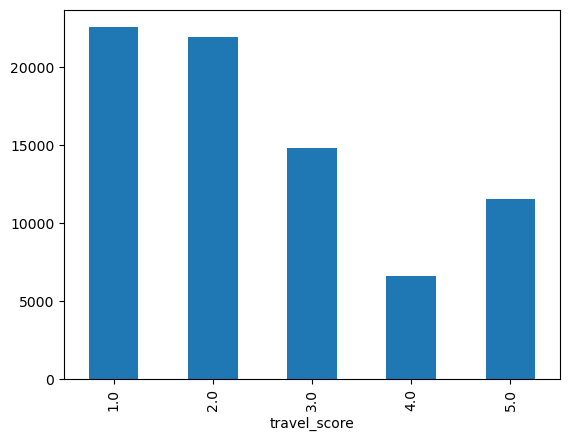

In [34]:
# Count the number of airbnb of each score, seems match the normal distribution and what map shows
# where good location airbnb are rare
count_scored = scored_data_df.toPandas()
count_scored.groupby(count_scored['travel_score']).size().plot(kind = 'bar')

In [25]:
# reduce plot data size for better plot mapping performance
#airbnb_df_filtered1 = scored_data_df.withColumn("new_id", airbnb_df_filtered["id"].cast("integer"))
#airbnb_df_filtered1 = airbnb_df_filtered1.filter(airbnb_df_filtered1.new_id > 500000)
#airbnb_df_filtered1 = airbnb_df_filtered1.filter(airbnb_df_filtered1.new_id % 5 == 0)
#airbnb_df_filtered1 = airbnb_df_filtered1.filter(airbnb_df_filtered1.new_id % 3 == 0)
#plot_df2 = count_scored
#plot_df1 = london_cluster_df
#plot_df2.head()

,listing_id,lat,lon,city,point,travel_score
0,Rome1000038128653158461,41.898350,12.503785,rome,"[41.89834976196289, 12.503785133361816]",5.0
1,Rome1000085573090116607,41.897854,12.503528,rome,"[41.89785385131836, 12.503527641296387]",5.0
2,Rome1000087947380625661,41.916294,12.421240,rome,"[41.91629409790039, 12.421239852905273]",1.0
3,Rome1000161932420441438,41.917599,12.515703,rome,"[41.917598724365234, 12.515703201293945]",4.0
4,Rome1000512975918982495,41.909512,12.491012,rome,"[41.90951156616211, 12.491011619567871]",4.0


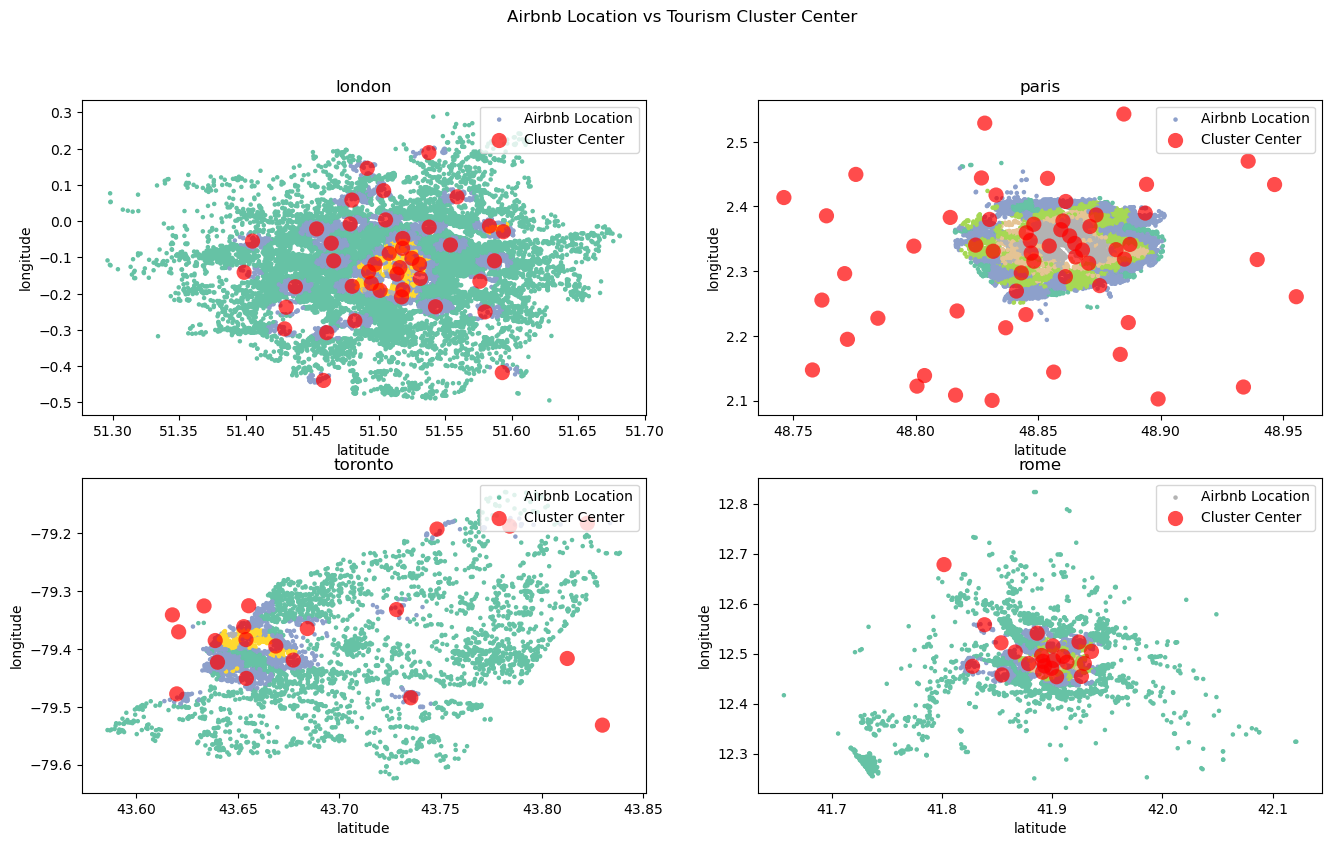

In [35]:
# plot the airbnb location with rating and compares to cluster center in each city
fig, axs = plt.subplots(2, 2, figsize=[16, 9])
city_name = {'london': axs[0, 0], 'paris': axs[0, 1], 'toronto': axs[1, 0], 'rome': axs[1, 1]}
for k, v in city_name.items():
    center_mask = combined_center_load_df['city'] == k
    airbnb_mask = count_scored['city'] == k
    center_data_pd1 = combined_center_load_df[center_mask]
    airbnb_data = count_scored[airbnb_mask]
    
    # used 5 color for 5 score ratings on airbnb location dots
    df_scatter = v.scatter(airbnb_data["lat"], airbnb_data["lon"], c=airbnb_data["travel_score"], cmap='Set2', s=5)
    rs_scatter = v.scatter(center_data_pd1["lat"], center_data_pd1["lon"], c='#FF0000', edgecolor='None', alpha=0.7, s=120)
    v.set_title(k)
    v.legend([df_scatter, rs_scatter], ['Airbnb Location', 'Cluster Center'], loc='upper right')
    
    
for ax in axs.flat:
    ax.set(xlabel='latitude', ylabel='longitude')
    
plt.suptitle("Airbnb Location vs Tourism Cluster Center")
plt.show()

In [37]:
# for transfer tourism score to final visualization offline
ready = scored_data_df.drop("lat","lon","point", "city")
ready.toPandas().to_csv("/travel_scored_airbnb.csv")